##Assignment 1 by Ishita Gupta (ID: 49003344)
  

###Requirements:
>1. [Dataloader ](https://colab.research.google.com/drive/1kojS_y5dB9VYYHqOwDHPvehHD9FDsAY6#scrollTo=g-Q5qXx0MZcI&line=8&uniqifier=1)
>2. [Regression Model](https://colab.research.google.com/drive/1kojS_y5dB9VYYHqOwDHPvehHD9FDsAY6#scrollTo=g-Q5qXx0MZcI&line=8&uniqifier=1)
>3. [Optimiser](https://colab.research.google.com/drive/1kojS_y5dB9VYYHqOwDHPvehHD9FDsAY6#scrollTo=g-Q5qXx0MZcI&line=8&uniqifier=1)
>4. [RMSE table](https://colab.research.google.com/drive/1kojS_y5dB9VYYHqOwDHPvehHD9FDsAY6#scrollTo=JgSYjvsRIBXX)
>5. [Highest correlated variable](https://colab.research.google.com/drive/1kojS_y5dB9VYYHqOwDHPvehHD9FDsAY6#scrollTo=2bG3_PrFN7aU&line=10&uniqifier=1)
>6. [L2 regularisation](https://colab.research.google.com/drive/1kojS_y5dB9VYYHqOwDHPvehHD9FDsAY6#scrollTo=ZU7AG5q4H5Rz&line=3&uniqifier=1)
>7. [Least Square Solution](https://colab.research.google.com/drive/1kojS_y5dB9VYYHqOwDHPvehHD9FDsAY6#scrollTo=SfZ3r5L2PPWI&line=6&uniqifier=1)


In [0]:
import numpy as np
import pandas as pd
import torch
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from torch.utils.data import Dataset, TensorDataset
from torch import Tensor
from torch.nn import Linear, MSELoss
from torch.optim import SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import PolynomialFeatures
import sklearn
import seaborn as sns 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

###Hyperparameters 
Below I will define the hyper parameters to fine tune the model. In this case I chose learning rate after experimenting.

In [0]:
#Hyper Parameters  

Batch_size_train= 101
Batch_size_test= 16
input_size = 13
output_size = 1
Learning_rate=2e-5
n_epochs = 4

col_names =  ['deg 1', 'deg 2', 'deg 3', 'deg 4']
my_df  = pd.DataFrame(columns = col_names)


###Boston Dataset
Here I us the sk_learn library to import the boston dataset. I then format it into the pandas dataframe. I chose the last feature MEDV as the target variable. After this I form correlation matrix between the other features and the target variable. As I can see that RM has the highest positive correlation(0.7) with MEDV so I choose this as the main feature for the rest of the experiments. (Single Variable Polynomial Regression - as clarified on LMS)

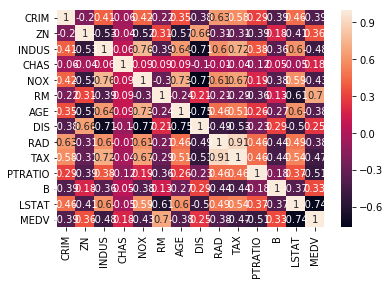

In [0]:
#load the dataset 

boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()
boston['MEDV'] = boston_dataset.target
correlation_matrix = boston.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

X = pd.DataFrame(boston['RM'], columns = ['RM'])
Y = boston['MEDV']

#We choose RM as it has the highest positive correlation with MEDV (Lsat couldve also been chosen )


##Polynomial Linear Regression 
>1. **Polynomial Features:** I used the sk.preprocessing library to get the function PolynomialFeatures. This generates the higher order features according to the polynomial degree. 
>2. **Regression Model:** I use torch.nn.Module to create a Linear model. This model is initialised to take in input size according to the polynomial degree. 
>3. **Loss:** I use the torch.optim library to call the MSE (Mean square error) and send in the model parameters. Using this, I calculate Root MSE by taking the square root during training steps. 
>4.**Optimiser:** I use stochastic gradient descent to optimise the training and quickly find minimum loss
>5. **Test-Train spilt:** I spilt the dataset after generating the higher order features
>6. **Dataloader:** I use the TensorDataset to create a Variable wrapper of the tensor objects from the training dataset. Then I use the Dataloader to create batches which can be used in the training step
 


###First Order Polynomial Regression

In [0]:
#creating polynomial features for the x terms eg. x , x^2 , x^3

poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X)

#Defining the model and setting the criterion for loss 

class LinearModel(torch.nn.Module):

    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc = torch.nn.Linear(poly.n_output_features_, output_size)

    def forward(self, x):
        return self.fc(x)
      
model = LinearModel()    
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_rate)


#print(X_train_poly)

#splitting the dataset into test set and train set 
X_train, X_test, Y_train, Y_test = train_test_split(X_train_poly, Y, test_size=0.2, random_state=1)


#implementing the pytorch Dataloader for the training set 
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
train_loader = DataLoader(dataset=train_data, batch_size=Batch_size_train, shuffle=True)
print('Linear Regression - First Degree polynomial ')
for i in range(20):
    for x,y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = torch.sqrt(criterion(y, outputs))
        loss.backward()
        optimizer.step()
    if i>0 :
        print('Epoch %d: RMSE loss = %g' % (i, loss))
        my_df.loc[i, 'deg 1'] = loss.detach().numpy()


Linear Regression - First Degree polynomial 
Epoch 1: RMSE loss = 19.84
Epoch 2: RMSE loss = 21.5852
Epoch 3: RMSE loss = 19.7693
Epoch 4: RMSE loss = 19.5395
Epoch 5: RMSE loss = 21.9788
Epoch 6: RMSE loss = 21.129
Epoch 7: RMSE loss = 22.0339
Epoch 8: RMSE loss = 21.6644
Epoch 9: RMSE loss = 20.5777
Epoch 10: RMSE loss = 21.768
Epoch 11: RMSE loss = 21.662
Epoch 12: RMSE loss = 20.1375
Epoch 13: RMSE loss = 21.6045
Epoch 14: RMSE loss = 20.4921
Epoch 15: RMSE loss = 21.9852
Epoch 16: RMSE loss = 21.6992
Epoch 17: RMSE loss = 21.4096
Epoch 18: RMSE loss = 20.7469
Epoch 19: RMSE loss = 20.5848


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([101, 1])) that is different to the input size (torch.Size([101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


###Second Order Polynomial Regression

In [0]:
#creating polynomial features for the x terms eg. x , x^2 , x^3

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X)
#print(X_train_poly)

#Defining the model and setting the criterion for loss 

class LinearModel(torch.nn.Module):

    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc = torch.nn.Linear(poly.n_output_features_, output_size)

    def forward(self, x):
        return self.fc(x)
      
model = LinearModel()    
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_rate)



#splitting the dataset into test set and train set 
X_train, X_test, Y_train, Y_test = train_test_split(X_train_poly, Y, test_size=0.2, random_state=1)


#implementing the pytorch Dataloader for the training set 
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
train_loader = DataLoader(dataset=train_data, batch_size=Batch_size_train, shuffle=True)

print('Linear Regression - Second Degree polynomial ')
for i in range(20):
    for x,y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = torch.sqrt(criterion(y, outputs))
        loss.backward()
        optimizer.step()
    if i > 0 :
        print('Epoch %d: RMSE loss = %g' % (i, loss))
        my_df.loc[i, 'deg 2'] = loss.detach().numpy()

Linear Regression - Second Degree polynomial 
Epoch 1: RMSE loss = 12.353
Epoch 2: RMSE loss = 14.2705
Epoch 3: RMSE loss = 15.0334
Epoch 4: RMSE loss = 14.773
Epoch 5: RMSE loss = 13.7659
Epoch 6: RMSE loss = 14.0791
Epoch 7: RMSE loss = 12.5128
Epoch 8: RMSE loss = 13.4052
Epoch 9: RMSE loss = 13.7903
Epoch 10: RMSE loss = 12.6746
Epoch 11: RMSE loss = 13.061
Epoch 12: RMSE loss = 14.1534
Epoch 13: RMSE loss = 13.4108
Epoch 14: RMSE loss = 13.2758
Epoch 15: RMSE loss = 12.9362
Epoch 16: RMSE loss = 13.5247
Epoch 17: RMSE loss = 12.9583
Epoch 18: RMSE loss = 13.2958
Epoch 19: RMSE loss = 12.1008


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([101, 1])) that is different to the input size (torch.Size([101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


###Third Order Polynomial Regression

In [0]:
#creating polynomial features for the x terms eg. x , x^2 , x^3

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X)

class LinearModel(torch.nn.Module):

    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc = torch.nn.Linear(poly.n_output_features_, output_size)

    def forward(self, x):
        return self.fc(x)
      
model = LinearModel()    
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_rate)


#print(X_train_poly)

#splitting the dataset into test set and train set 
X_train, X_test, Y_train, Y_test = train_test_split(X_train_poly, Y, test_size=0.2, random_state=1)


#implementing the pytorch Dataloader for the training set 
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
train_loader = DataLoader(dataset=train_data, batch_size=Batch_size_train, shuffle=True)
print('Linear Regression - Third Degree polynomial ')
for i in range(20):
    for x,y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = torch.sqrt(criterion(y, outputs))
        loss.backward()
        optimizer.step()
    if i > 0:
        print('Epoch %d: RMSE loss = %g' % (i, loss))
        my_df.loc[i, 'deg 3'] = loss.detach().numpy()

Linear Regression - Third Degree polynomial 
Epoch 1: RMSE loss = 105.713
Epoch 2: RMSE loss = 105.274
Epoch 3: RMSE loss = 96.8919
Epoch 4: RMSE loss = 93.0688
Epoch 5: RMSE loss = 87.7977
Epoch 6: RMSE loss = 77.9291
Epoch 7: RMSE loss = 75.5535
Epoch 8: RMSE loss = 67.1346
Epoch 9: RMSE loss = 65.2219
Epoch 10: RMSE loss = 58.4227
Epoch 11: RMSE loss = 54.8433
Epoch 12: RMSE loss = 46.256
Epoch 13: RMSE loss = 41.0469
Epoch 14: RMSE loss = 35.3102
Epoch 15: RMSE loss = 30.8537
Epoch 16: RMSE loss = 23.5441
Epoch 17: RMSE loss = 21.7909
Epoch 18: RMSE loss = 15.8961
Epoch 19: RMSE loss = 13.1734


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([101, 1])) that is different to the input size (torch.Size([101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


###Fourth Order Polynomial Regression

In [0]:
#creating polynomial features for the x terms eg. x , x^2 , x^3

poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X)
#print(X_train_poly)

class LinearModel(torch.nn.Module):

    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc = torch.nn.Linear(poly.n_output_features_, output_size)

    def forward(self, x):
        return self.fc(x)
      
model = LinearModel()    
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_rate)


#splitting the dataset into test set and train set 
X_train, X_test, Y_train, Y_test = train_test_split(X_train_poly, Y, test_size=0.2, random_state=1)


#implementing the pytorch Dataloader for the training set 
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
train_loader = DataLoader(dataset=train_data, batch_size=Batch_size_train, shuffle=True)
print('Linear Regression - Fourth Degree polynomial ')
for i in range(20):
    for x,y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = torch.sqrt(criterion(y, outputs))
        loss.backward()
        optimizer.step()
    if i > 0:
        print('Epoch %d: RMSE loss = %g' % (i, loss))
        my_df.loc[i, 'deg 4'] = loss.detach().numpy()


Linear Regression - Fourth Degree polynomial 
Epoch 1: RMSE loss = 38.7042
Epoch 2: RMSE loss = 40.6532
Epoch 3: RMSE loss = 38.3222
Epoch 4: RMSE loss = 31.9211
Epoch 5: RMSE loss = 32.5969
Epoch 6: RMSE loss = 34.2323
Epoch 7: RMSE loss = 31.4495
Epoch 8: RMSE loss = 36.5772
Epoch 9: RMSE loss = 31.4009
Epoch 10: RMSE loss = 42.4355
Epoch 11: RMSE loss = 30.2715
Epoch 12: RMSE loss = 33.1319
Epoch 13: RMSE loss = 36.0705
Epoch 14: RMSE loss = 33.1304
Epoch 15: RMSE loss = 36.6386
Epoch 16: RMSE loss = 33.7369
Epoch 17: RMSE loss = 36.8881
Epoch 18: RMSE loss = 30.6724
Epoch 19: RMSE loss = 28.0891


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([101, 1])) that is different to the input size (torch.Size([101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [0]:
print("Loss: ")
print(my_df)

Loss: 
        deg 1       deg 2      deg 3      deg 4
1   19.840046   12.352972  105.71282  38.704224
2    21.58517   14.270532  105.27368   40.65324
3   19.769316   15.033435   96.89186  38.322186
4   19.539513   14.772981  93.068794  31.921146
5   21.978773    13.76592   87.79765   32.59688
6   21.128973   14.079081   77.92911   34.23226
7   22.033854   12.512827   75.55351   31.44952
8    21.66439  13.4052305   67.13455  36.577187
9   20.577679   13.790313  65.221886  31.400875
10  21.768042  12.6746235  58.422665   42.43554
11  21.661964   13.060992  54.843338  30.271526
12  20.137535   14.153357     46.256   33.13188
13  21.604517  13.4108305   41.04691   36.07053
14  20.492111   13.275819  35.310154   33.13043
15  21.985228    12.93622   30.85368  36.638557
16  21.699186   13.524677  23.544123   33.73694
17  21.409557   12.958347  21.790855  36.888084
18  20.746948   13.295844  15.896116  30.672379
19  20.584782   12.100812   13.17339  28.089113


We can see from the RMSE values that the First order linear polynomial and Second order linear polynomial are the best choices
We will now chose the second order Linear polynomial as our first choice and use a regulariser

###Regulariser
We create a L2 regulariser by adding a weight decay term to the SGD optimiser 

In [0]:
# Implementing the L2 regulariser by adding a weight decay term to our SGD optimiser 

optimizer = torch.optim.SGD(model.parameters(), lr=Learning_rate, weight_decay=1e-5)

In [0]:
#creating polynomial features for the x terms eg. x , x^2 , x^3

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X)
#print(X_train_poly)

#Defining the model and setting the criterion for loss 

class LinearModel(torch.nn.Module):

    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc = torch.nn.Linear(poly.n_output_features_, output_size)

    def forward(self, x):
        return self.fc(x)
      
model = LinearModel()    
criterion = torch.nn.MSELoss()




#splitting the dataset into test set and train set 
X_train, X_test, Y_train, Y_test = train_test_split(X_train_poly, Y, test_size=0.2, random_state=1)


#implementing the pytorch Dataloader for the training set 
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
train_loader = DataLoader(dataset=train_data, batch_size=Batch_size_train, shuffle=True)

print('Linear Regression - Second Degree polynomial ')
for i in range(20):
    for x,y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = torch.sqrt(criterion(y, outputs))
        loss.backward()
        optimizer.step()
    if i > 0 :
        print('Epoch %d: RMSE loss = %g' % (i, loss))

Linear Regression - Second Degree polynomial 
Epoch 1: RMSE loss = 20.5384
Epoch 2: RMSE loss = 19.6284
Epoch 3: RMSE loss = 20.8511
Epoch 4: RMSE loss = 20.3363
Epoch 5: RMSE loss = 21.3614
Epoch 6: RMSE loss = 21.83
Epoch 7: RMSE loss = 21.7624
Epoch 8: RMSE loss = 21.831
Epoch 9: RMSE loss = 20.5745
Epoch 10: RMSE loss = 20.6662
Epoch 11: RMSE loss = 19.6367
Epoch 12: RMSE loss = 21.1036
Epoch 13: RMSE loss = 18.6867
Epoch 14: RMSE loss = 21.1259
Epoch 15: RMSE loss = 20.0771
Epoch 16: RMSE loss = 21.8648
Epoch 17: RMSE loss = 20.3463
Epoch 18: RMSE loss = 20.8425
Epoch 19: RMSE loss = 21.1522


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([101, 1])) that is different to the input size (torch.Size([101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Least Square Solution 
Instead of using the MSE as our loss function, we implement the closed form square solution using the LinearRegression() function of Ski_learn library (as it implments it automatically)

We can clearly see from the loss values from the closed form solution is better than SGD optimisation. It is also computationally faster. 

In [0]:
#creating polynomial features for the x terms eg. x , x^2 , x^3

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X)
#print(X_train_poly)

#splitting the dataset into test set and train set 
X_train, X_test, Y_train, Y_test = train_test_split(X_train_poly, Y, test_size=0.2, random_state=1)


model = LinearRegression().fit(X_train,Y_train) 
model.score(X_train,Y_train)

0.5135738738223767